# Supervised Learning II – Klassifikation mit Logistischer Regression

## Lernziele

Am Ende dieses Notebooks kannst du:

* den Unterschied zwischen Regressions- und Klassifikationsproblemen erklären,
* Klassifikationsmodelle mit Scikit-learn trainieren und bewerten,
* die logistische Regression auf geeignete Probleme anwenden und
* gängige Metriken zur Evaluation von Klassifikationsmodellen interpretieren.

# Klassifikation mit Logistischer Regression

## Einführung in die Klassifikation

Bisher haben wir uns mit **Regression** beschäftigt, also dem Vorhersagen von kontinuierlichen Größen, zum Beispiel der Fertigungsdauer in Minuten auf Basis der Maschinenanzahl. Doch in vielen praktischen Anwendungen interessiert uns nicht ein kontinuierlicher Zahlenwert, sondern eine **Zugehörigkeit zu einer Kategorie**:

* Ist ein Produkt defekt oder nicht?
* Handelt es sich bei einem Bildinhalt um eine Katze oder einen Hund?
* Wird ein Kunde den Vertrag kündigen: ja oder nein?

Solche Aufgaben zählen zum **Klassifikationsproblem**, einer eigenen Klasse des Supervised Learning. Die Zielvariable $y$ ist dabei **nicht kontinuierlich**, sondern **diskret** – oft binär (z.B. 0/1, ja/nein), oft auch mehrstufig (z.B. Klassen A, B, C).

### Beispiel: Defekte Steckverbindungen

Stellen wir uns vor, wir arbeiten in der Qualitätssicherung eines Unternehmens, das Steckverbindungen für Fahrzeuge herstellt. Bei jeder Verbindung messen wir zwei Größen:

* die **Kontaktnormalkraft** (x-Achse): wie stark wird der Stecker in die Buchse gedrückt?
* den **elektrischen Kontaktwiderstand** (y-Achse): je geringer dieser ist, desto besser leitet die Verbindung Strom.

Die Unternehmensdevise ist: Ein Kontakt mit einem Widerstand von über **300 mΩ** gilt als **defekt** und wird gewartet.

Die folgende Grafik zeigt eine Stichprobe unserer Steckverbindungen. Jede Verbindung ist entweder **defekt** (oranges Dreieck) oder **nicht defekt** (grünes Quadrat):

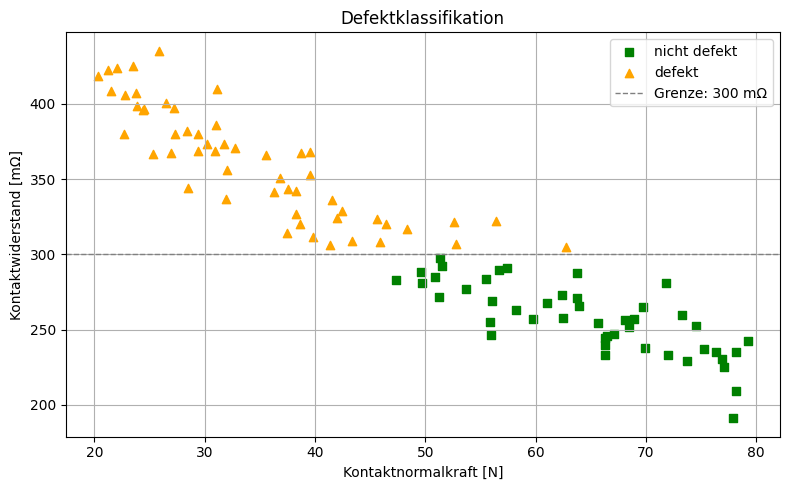

In [15]:
import matplotlib.pyplot as plt
import pandas as pd

data = pd.read_csv('../Data/classification_data_resistance_force.csv')

force = data['Normalkraft']
resistance = data['Widerstand']
is_defective = resistance > 300

fig, ax = plt.subplots(figsize= (8,5))
ax.scatter(force[~is_defective], resistance[~is_defective],
            c='green', marker='s', label='nicht defekt')
ax.scatter(force[is_defective], resistance[is_defective],
            c='orange', marker='^', label='defekt')
ax.axhline(300, color='gray', linestyle='--', linewidth=1, label='Grenze: 300 mΩ')

plt.xlabel("Kontaktnormalkraft [N]")
plt.ylabel("Kontaktwiderstand [mΩ]")
plt.title("Defektklassifikation")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In der Grafik ist klar zu erkennen: Defekte Verbindungen haben meist **niedrigere Kontaktnormalkräfte** und **höhere Widerstände**. Unser Ziel ist es nun, ein Modell zu bauen, das diese Regel **automatisch erlernt**, um bei zukünftigen Steckverbindungen allein anhand der Kontaktkraft schnell und zuverlässig eine Entscheidung treffen zu können: defekt oder nicht?

Wir brauchen also eine binäre Ausgabe (0 = defekt, 1 = nicht defekt) oder, noch nützlicher, eine Ausgabe, die uns sagt mit welcher Wahrscheinlichkeit ein Datenpunkt einen defekten Stecker beschreibt. Und genau hier kommt die **logistische Funktion** (oder Sigmoid-Funktion) ins Spiel.

## Zutat 1: Das logistische Modell

Der Schlüssel, um von der Regression zur (binären) Klassifikation zu gelangen, liegt in der Transformation der Eingangsdaten zu einem Wert zwischen 0 und 1, den wir als **Wahrscheinlichkeit für die Zugehörigkeit zur Klasse 1** interpretieren können. In unserem Fall definieren wir willkürlich Klasse 1 = *defekt*.

### Die Sigmoidfunktion

Um aus einem beliebigen Eingangswert $x$ eine Vorhersage zwischen 0 und 1 zu erzeugen, verwenden wir die sogenannte **Sigmoidfunktion**:

$$
\sigma(z) = \frac{1}{1 + e^{-z}}
\tag{1}
$$

wobei  $z = w \cdot x + b$ einfach eine lineare Vorhersage ist. Konkret heißt das, dass wir bei der logistischen Regression einfach eine lineare Funktion als Vorhersage nehmen und dann eine nichtlineare Funktion, die Sigmoid-Funktion, darauf anwenden, um die Vorhersage auf einen Bereich zwischen 0 und 1 zu beschränken. Die Sigmoid-Funktion sieht dann so aus:

![](../Images/sigmoid.png)

Die Sigmoidfunktion (1) hat folgende Eigenschaften:

* Sie nimmt beliebige reelle Zahlen als Eingabe und gibt einen Wert im Bereich $(0, 1)$ zurück.
* Negative Werte führen zu Ausgaben nahe 0, große positive Werte zu Ausgaben nahe 1.
* Sie ist **glatt** und **differenzierbar**, was für das Training mit Gradientenverfahren (später mehr dazu) wichtig ist.

Damit ergibt sich das vollständige Modell der logistischen Regression:

$$
\hat{y} = \sigma(w \cdot x + b)
$$

Hierbei ist $\hat{y}$ die vom Modell vorhergesagte Wahrscheinlichkeit, dass die Instanz zur **positiven Klasse** gehört (z. B. *defekt*). Um daraus eine konkrete Klassenzuordnung zu treffen, kann man einen **Schwellwert** setzen (z. B. 0.5):
Wenn $\hat{y} \geq 0.5$, klassifizieren wir die Verbindung als *defekt*, andernfalls als *nicht defekt*.

### Warum heißt es eigentlich logistische „Regression“?

Obwohl die **logistische Regression** ein Modell zur **Klassifikation** ist, trägt sie den Begriff *Regression* im Namen. Mit dem Wissen über die Sigmoid-Funktion lässt sich das nun einfach rechtfertigen: Letztendlich bestimmen wir immer noch die Parameter $w$ und $b$ um einen möglichst guten "Fit" an die Daten zu erlangen. Allein die **Nutzung der logistischen Funktion** ermöglicht es uns, diese lineare Vorhersage so zu transformieren, dass sie sich **für ein Klassifikationsproblem eignet**. Dahinter steckt aber, genau wie bei der linearen Regression, eine geeignete Wahl der Modellparameter, so dass der Vorhersagefehler minimiert wird. 

Aber welcher Fehler ist das eigentlich? Können wir ebenfalls weiterhin mit der MSE-Verlustfunktion arbeiten? Genau das schauen wir uns im nächsten Abschnitt an.

## Zutat 2: Die Verlustfunktion - Cross-Entropy

Im obigen Beispiel haben wir zwei Klassen, *defekt* (Klasse 1) und *nicht defekt* (Klasse 0), und wollen auf Basis der Normalkraft bestimmen, ob eine Steckverbindung zur Klasse 1 oder 0 gehört. Es handelt sich hierbei um eine **binäre Klassifikation**, da wir nur zwei mögliche Klassen haben. 

Wir wissen, dass unser Modell eine Zahl zwischen 0 und 1 ausgibt, welche die Wahrscheinlichkeit darstellt, dass ein Datenpunkt zur Klasse 1 gehört. Alle $\hat{y}$ über $0.5$ werden dabei als Klasse 1 gewertet, da die Wahrscheinlichkeit größer als 50% beträgt. Je höher der Wert, desto größer die "Sicherheit" des Modells. Obwohl wir also nur einen Wert als Ausgabe bekommen, können wir zwei Sachen daraus ableiten:

1. "Ist die Vorhersage richtig oder falsch?" und
2. "Wie sicher ist sich das Modell?"

Was wir von einer geeigneten Fehlerfunktion erwarten ist klar: 
- Eine falsche Vorhersage soll einen höheren Fehler haben als eine richtige. 

Es sind aber zwei weitere Sachen wichtig:
- Eine falsche Vorhersage, die mit hoher Sicherheit getroffen wurde, soll stärker bestraft werden.
- Eine Vorhersage nahe $0.5$ soll nicht belohnt werden, da sie keine Information gibt.

Ein naheliegender Vorschlag ist die Verwendung des mittleren quadratischen Fehlers (MSE), den wir bereits aus der linearen Regression kennen:

$$
\mathrm{MSE} = (\hat{y} - y)^2
$$

Aber dieser Fehler misst nur den Abstand zwischen Vorhersage $\hat{y}$ und Zielwert $y$, ohne die Unsicherheit der Vorhersage sinnvoll zu berücksichtigen: Angenommen, das richtige Label sei $y = 1$. Die Vorhersage $\hat{y} = 0$, also die schlechteste Vorhersage, die überhaupt möglich ist, liefert einen MSE von $1$, was bereits ein ziemlich niedriger Wert ist. Am besten wäre es, wenn der Fehler unbegrenzt ansteigen würde, je weiter man sich der falschen Klasse nähert. Der MSE ist also nicht gut geeignet für Klassifikation, weil er nicht die Wahrscheinlichkeit für das richtige Label berücksichtigt, sondern nur die Differenz der Zahlen.

Wir werden nun sehen, dass wir eine geeignetere Fehlerfunktion erhalten können, wenn wir sie mit dem sogenannten Maximum-Likelihood-Ansatz herleiten.

### Maximum Likelihood Estimation


## Die Minimierung des Fehlers

# Hands-On: Logistische Regression für TODO

## Inspektion

## Preprocessing

## Klassifikation

## Evaluation des Modells

### 1. Accuracy

### 2. Precision

### 3. Recall

### 4. F1

### 5. Weitere Metriken

In [34]:
import numpy as np
import plotly.graph_objs as go

x = np.linspace(0.001, .999, 100)
y = np.linspace(0.001, .999, 100)

X, Y = np.meshgrid(x, y)

mask_1 = (X > 0.9) & (X < .999)
mask_2 = (X > 0.4) & (X < 0.6)
mask_3 = (X > 0.001) & (X < 0.1)
X_1 = np.where(mask_1, X, np.nan)
X_2 = np.where(mask_2, X, np.nan)
X_3 = np.where(mask_3, X, np.nan)


# Cross-Entropy und MSE für alle Bereiche berechnen
Z_LOG_1 = - np.log(X_1**Y * (1-X_1)**(1-Y))
Z_MSE_1 = (X_1 - Y)**2

Z_LOG_2 = - np.log(X_2**Y * (1-X_2)**(1-Y))
Z_MSE_2 = (X_2 - Y)**2

Z_LOG_3 = - np.log(X_3**Y * (1-X_3)**(1-Y))
Z_MSE_3 = (X_3 - Y)**2

# Basisfläche für Cross-Entropy (alle X/Y)
Z_LOG = - np.log(X**Y * (1-X)**(1-Y))
Z_MSE = (X - Y)**2

# Maskierte Bereiche als zusätzliche Flächen
surface_log_1 = go.Surface(x=X, y=Y, z=Z_LOG_1, colorscale='Oranges', opacity=0.8, showscale=False, name='CE: X>0.9')
surface_log_2 = go.Surface(x=X, y=Y, z=Z_LOG_2, colorscale='Blues', opacity=0.8, showscale=False, name='CE: X~0.5')
surface_log_3 = go.Surface(x=X, y=Y, z=Z_LOG_3, colorscale='Greens', opacity=0.8, showscale=False, name='CE: X<0.1')

surface_mse_1 = go.Surface(x=X, y=Y, z=Z_MSE_1, colorscale='Reds', opacity=0.5, showscale=False, name='MSE: X>0.9')
surface_mse_2 = go.Surface(x=X, y=Y, z=Z_MSE_2, colorscale='Purples', opacity=0.5, showscale=False, name='MSE: X~0.5')
surface_mse_3 = go.Surface(x=X, y=Y, z=Z_MSE_3, colorscale='Greys', opacity=0.5, showscale=False, name='MSE: X<0.1')

layout = go.Layout(
    scene=dict(
        xaxis=dict(title=r'$\hat{y}$', range=[0, 1]),
        yaxis=dict(title=r'$y$', range=[0, 1]),
        zaxis_title='Loss'
    ),
    width=900,
    height=700,
    title='Vergleich: Cross-Entropy vs. MSE'
)

fig = go.Figure(data=[
    surface_log_1, surface_log_2, surface_log_3,
    surface_mse_1, surface_mse_2, surface_mse_3
], layout=layout)

fig.show()

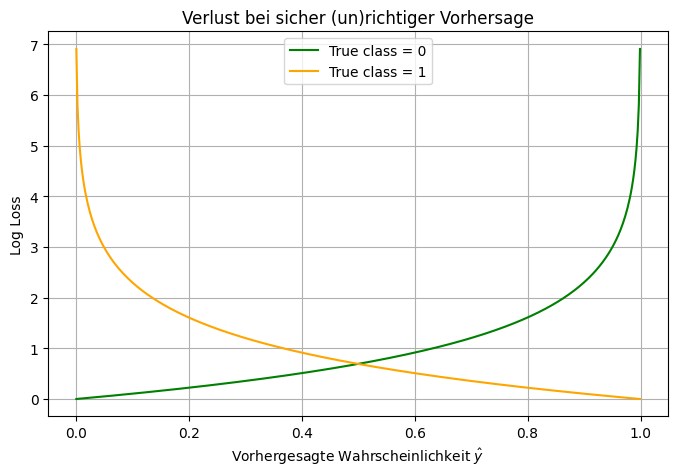

In [12]:
import numpy as np
import matplotlib.pyplot as plt

yhat = np.linspace(0.001, 0.999, 500)
loss_0 = -np.log(1 - yhat)
loss_1 = -np.log(yhat)

plt.figure(figsize=(8, 5))
plt.plot(yhat, loss_0, label="True class = 0", color="green")
plt.plot(yhat, loss_1, label="True class = 1", color="orange")
plt.xlabel(r"Vorhergesagte Wahrscheinlichkeit $\hat{y}$")
plt.ylabel("Log Loss")
plt.title("Verlust bei sicher (un)richtiger Vorhersage")
plt.legend()
plt.grid(True)
plt.show()


In [13]:
import pandas as pd

df = pd.DataFrame({
    "x": ["A", "B", "C"],
    "true_label": [1, 0, 1],
    "predicted_prob": [0.9, 0.3, 0.6]
})

df["P(y_i)"] = df["true_label"] * df["predicted_prob"] + (1 - df["true_label"]) * (1 - df["predicted_prob"])
df["log_P(y_i)"] = np.log(df["P(y_i)"])

df


x  true_label  predicted_prob  P(y_i)  log_P(y_i)
0  A           1             0.9     0.9   -0.105361
1  B           0             0.3     0.7   -0.356675
2  C           1             0.6     0.6   -0.510826

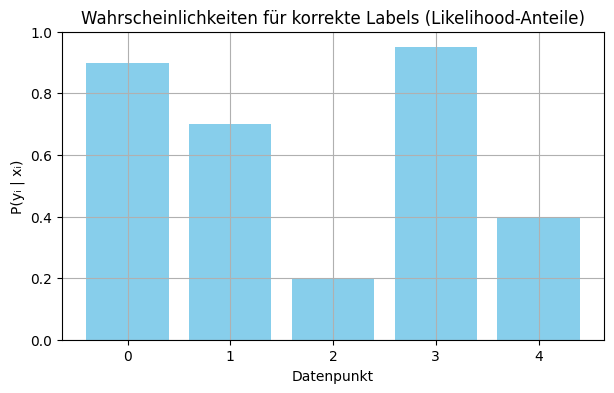

In [14]:
import matplotlib.pyplot as plt

true_probs = [0.9, 0.7, 0.2, 0.95, 0.4]  # Modellvorhersagen für richtige Klasse
indices = range(len(true_probs))

plt.figure(figsize=(7, 4))
plt.bar(indices, true_probs, color="skyblue")
plt.title("Wahrscheinlichkeiten für korrekte Labels (Likelihood-Anteile)")
plt.xlabel("Datenpunkt")
plt.ylabel("P(yᵢ | xᵢ)")
plt.ylim(0, 1)
plt.grid(True)
plt.show()
